In [2]:
from stable_baselines3 import SAC, TD3, PPO
import gymnasium as gym
import mujoco

print("WORKS!")


WORKS!


In [34]:
import os
import time
from typing import Dict, Any, List
from stable_baselines3.common.vec_env import VecNormalize

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

plt.rcParams["figure.figsize"] = (8, 5)

print("Imports OK")


Imports OK


In [7]:
env_id = "InvertedDoublePendulum-v4"
env = gym.make(env_id)
obs, info = env.reset()
print("Env loaded, obs shape:", obs.shape)
env.close()


/Users/macbook/Documents/AUA/rl-project/rl-venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment InvertedDoublePendulum-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Env loaded, obs shape: (11,)


In [8]:
# ======================
# 1. Logging Callback
# ======================

class RewardLoggingCallback(BaseCallback):
    """
    Logs episode rewards during training.
    Works with Monitor wrapper.
    """

    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        # Monitor puts 'episode' info in infos list
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
                self.episode_lengths.append(info["episode"]["l"])
        return True


# ======================
# 2. Environment Factory
# ======================

def make_env(env_id: str, seed: int = 0):
    """
    Returns a Monitor-wrapped, seeded Gymnasium environment.
    """
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed)
        env = Monitor(env)
        return env
    return _init

print("Utils 1 loaded")


Utils 1 loaded


In [48]:
# ======================
# 3. Training Function
# ======================

def train_agent(
    algo_name: str,
    env_id: str = "InvertedDoublePendulum-v4",
    total_timesteps: int = 150_000,
    seed: int = 0,
    hyperparams: Dict[str, Any] = None,
    log_dir: str = "./logs"
):
    """
    Train SAC / TD3 / PPO on InvertedDoublePendulum.

    Returns:
        model, callback (with episode rewards), training_time_seconds
    """
    os.makedirs(log_dir, exist_ok=True)

    if hyperparams is None:
        hyperparams = {}

    env_fn = make_env(env_id, seed)
    vec_env = DummyVecEnv([env_fn])

    if algo_name.upper() == "SAC":
        ModelClass = SAC
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=3e-4,
            buffer_size=1_000_000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            train_freq=1,
            gradient_steps=1,
            learning_starts=10_000,
            verbose=0
        )
    elif algo_name.upper() == "TD3":
        ModelClass = TD3
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=1e-3,
            buffer_size=1_000_000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            train_freq=1,
            gradient_steps=1,
            learning_starts=10_000,
            policy_delay=2,
            verbose=0
        )
    elif algo_name.upper() == "PPO":
        ModelClass = PPO
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            verbose=0
        )
    else:
        raise ValueError(f"Unknown algo_name: {algo_name}")

    default_params.update(hyperparams)

    tb_log_dir = os.path.join(log_dir, f"{algo_name}_tb")
    os.makedirs(tb_log_dir, exist_ok=True)

    model = ModelClass(
        env=vec_env,
        tensorboard_log=tb_log_dir,
        seed=seed,
        **default_params
    )

    callback = RewardLoggingCallback()

    start_time = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    training_time = time.time() - start_time

    return model, callback, training_time

print("Training function loaded")


Training function loaded


In [10]:
# ======================
# 4. Evaluation Functions
# ======================

def evaluate_deterministic_policy(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    n_eval_episodes: int = 10,
    render: bool = False
):
    """
    Evaluate the deterministic (greedy) policy.
    For SAC/TD3 this means deterministic=True.
    For PPO, deterministic=True picks the mode of the distribution.
    """
    eval_env = gym.make(env_id)
    eval_env = Monitor(eval_env)

    mean_reward, std_reward = evaluate_policy(
        model,
        eval_env,
        n_eval_episodes=n_eval_episodes,
        render=render,
        deterministic=True,
        return_episode_rewards=False
    )

    eval_env.close()
    return mean_reward, std_reward


def rollout_trajectory(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    deterministic: bool = True,
    max_steps: int = 1000
):
    """
    Run a single trajectory and return states, actions, rewards.
    """
    env = gym.make(env_id)
    obs, info = env.reset()
    states = []
    actions = []
    rewards = []

    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        next_obs, reward, terminated, truncated, info = env.step(action)

        states.append(obs)
        actions.append(action)
        rewards.append(reward)

        obs = next_obs
        if terminated or truncated:
            break

    env.close()
    return np.array(states), np.array(actions), np.array(rewards)

print("Evaluation utils loaded")


Evaluation utils loaded


In [11]:
# ======================
# 5. Plotting
# ======================

def plot_learning_curves(
    algo_results: Dict[str, List[float]],
    window: int = 10,
    save_path: str = None
):

    plt.figure()
    for algo_name, rewards in algo_results.items():
        rewards = np.array(rewards, dtype=np.float32)
        if len(rewards) == 0:
            continue
        # Moving average
        if len(rewards) >= window:
            mov_avg = np.convolve(rewards, np.ones(window)/window, mode="valid")
        else:
            mov_avg = rewards
        plt.plot(mov_avg, label=algo_name)

    plt.xlabel(f"Episode (smoothed over {window})")
    plt.ylabel("Episode Reward")
    plt.title("Learning Curves: InvertedDoublePendulum")
    plt.legend()
    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()

print("Plotting utils loaded")


Plotting utils loaded



==================== TUNING SAC ====================
[SAC] Trial 1/6  score=9358.45  seeds=[9359.8617206, 9355.6300916, 9359.8580108]  hp={'learning_rate': 0.0020080373301738963, 'batch_size': 256, 'tau': 0.003483438607263992, 'gamma': 0.9711530253807622, 'train_freq': 8, 'gradient_steps': 2, 'learning_starts': 10000}
[SAC] Trial 2/6  score=9359.87  seeds=[9359.9341476, 9359.862829400001, 9359.819919000001]  hp={'learning_rate': 0.0002987008386012388, 'batch_size': 512, 'tau': 0.009776599864738916, 'gamma': 0.9967884065636865, 'train_freq': 8, 'gradient_steps': 1, 'learning_starts': 10000}
[SAC] Trial 3/6  score=9357.06  seeds=[9357.9993546, 9359.7351042, 9353.45955]  hp={'learning_rate': 0.0024058766004845062, 'batch_size': 256, 'tau': 0.006538545355367981, 'gamma': 0.9815635769863605, 'train_freq': 4, 'gradient_steps': 1, 'learning_starts': 5000}
[SAC] Trial 4/6  score=9359.10  seeds=[9359.0002888, 9359.2484952, 9359.046827400001]  hp={'learning_rate': 0.0006203779517599353, 'batch_

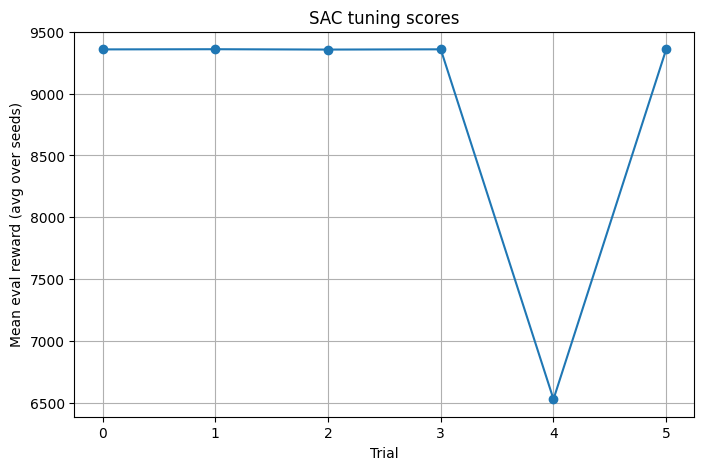


[SAC] BEST HP: {'learning_rate': 0.0002987008386012388, 'batch_size': 512, 'tau': 0.009776599864738916, 'gamma': 0.9967884065636865, 'train_freq': 8, 'gradient_steps': 1, 'learning_starts': 10000}
[SAC] BEST TUNING SCORE: 9359.87 (avg over seeds)

==================== FINAL TRAIN SAC ====================
[SAC] FINAL eval: mean=9358.41 +/- 0.07
[SAC] FINAL train time: 325.5s

==================== TUNING TD3 ====================
[TD3] Trial 1/6  score=31.89  seeds=[31.903495, 33.559992199999996, 30.214149]  hp={'learning_rate': 0.0020080373301738963, 'batch_size': 256, 'tau': 0.003483438607263992, 'gamma': 0.9711530253807622, 'train_freq': 8, 'gradient_steps': 2, 'learning_starts': 10000, 'policy_delay': 2}
[TD3] Trial 2/6  score=31.92  seeds=[31.945894400000004, 33.5798604, 30.234694400000002]  hp={'learning_rate': 0.002338276047810711, 'batch_size': 256, 'tau': 0.013410364840559847, 'gamma': 0.9917182924884834, 'train_freq': 8, 'gradient_steps': 1, 'learning_starts': 10000, 'policy_de

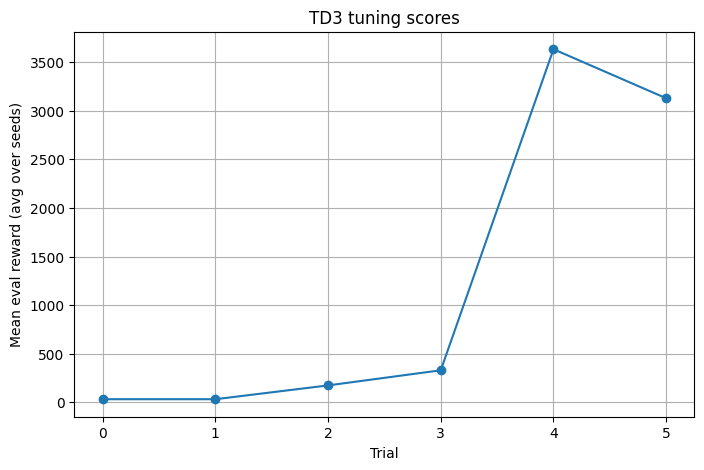


[TD3] BEST HP: {'learning_rate': 0.00047500508429902053, 'batch_size': 512, 'tau': 0.012338623153026184, 'gamma': 0.9805474984256821, 'train_freq': 8, 'gradient_steps': 1, 'learning_starts': 5000, 'policy_delay': 1}
[TD3] BEST TUNING SCORE: 3633.25 (avg over seeds)

==================== FINAL TRAIN TD3 ====================
[TD3] FINAL eval: mean=8996.93 +/- 1581.69
[TD3] FINAL train time: 378.1s

==================== TUNING PPO ====================
[PPO] Trial 1/6  score=360.13  seeds=[396.86522560000003, 378.67936879999996, 304.8595626]  hp={'learning_rate': 0.00037965564112903214, 'n_steps': 512, 'batch_size': 256, 'n_epochs': 10, 'gamma': 0.9759322480780381, 'gae_lambda': 0.9238042537806193, 'clip_range': 0.21910894059585032}
[PPO] Trial 2/6  score=384.96  seeds=[492.09256939999995, 367.1310022, 295.646162]  hp={'learning_rate': 0.0004351923352065248, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 10, 'gamma': 0.9808437140953058, 'gae_lambda': 0.870146536284707, 'clip_range': 0.27

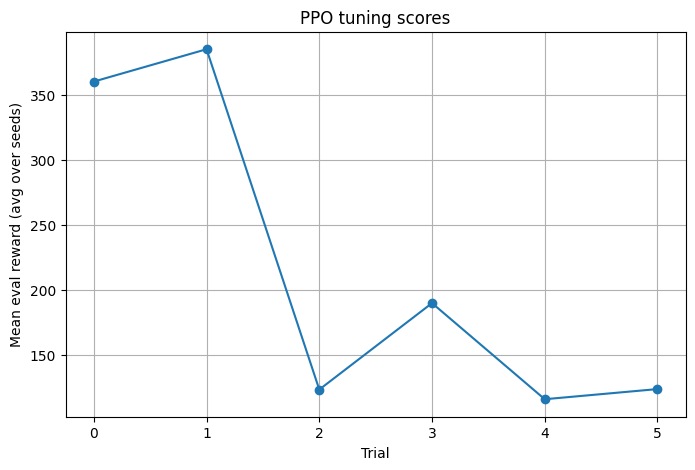


[PPO] BEST HP: {'learning_rate': 0.0004351923352065248, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 10, 'gamma': 0.9808437140953058, 'gae_lambda': 0.870146536284707, 'clip_range': 0.2784687458892267}
[PPO] BEST TUNING SCORE: 384.96 (avg over seeds)

==================== FINAL TRAIN PPO ====================
[PPO] FINAL eval: mean=1822.04 +/- 471.91
[PPO] FINAL train time: 66.9s

==================== BEST OVERALL ====================
Best algo: SAC Final eval: (np.float64(9358.412180199997), np.float64(0.07009528167980535))
Saved tuned SAC model to ./best_tuned_models/SAC_BEST_TUNED_inverted_double_pendulum
Saved tuned TD3 model to ./best_tuned_models/TD3_BEST_TUNED_inverted_double_pendulum
Saved tuned PPO model to ./best_tuned_models/PPO_BEST_TUNED_inverted_double_pendulum
Best model saved under: ./best_tuned_models/SAC_BEST_TUNED_inverted_double_pendulum


In [13]:
# ======================
# 6. Hyperparameter Tuning (Copy-Paste)
# ======================

import json
import numpy as np

def _sample_from_space(space: Dict[str, Any], rng: np.random.RandomState) -> Dict[str, Any]:
    """
    space format:
      - ("loguniform", low, high)
      - ("uniform", low, high)
      - ("int", low, high)
      - ("choice", [v1, v2, ...])
    """
    hp = {}
    for k, spec in space.items():
        kind = spec[0]
        if kind == "loguniform":
            low, high = float(spec[1]), float(spec[2])
            hp[k] = float(10 ** rng.uniform(np.log10(low), np.log10(high)))
        elif kind == "uniform":
            low, high = float(spec[1]), float(spec[2])
            hp[k] = float(rng.uniform(low, high))
        elif kind == "int":
            low, high = int(spec[1]), int(spec[2])
            hp[k] = int(rng.randint(low, high + 1))
        elif kind == "choice":
            choices = spec[1]
            hp[k] = choices[int(rng.randint(0, len(choices)))]
        else:
            raise ValueError(f"Unknown spec kind: {kind} for key {k}")
    return hp


def _fix_ppo_params(hp: Dict[str, Any]) -> Dict[str, Any]:
    """
    SB3 PPO needs: (n_steps * n_envs) % batch_size == 0. Here n_envs=1 (DummyVecEnv with 1 env).
    Also batch_size should be <= n_steps.
    """
    hp = dict(hp)
    n_steps = int(hp.get("n_steps", 2048))
    batch_size = int(hp.get("batch_size", 64))

    if batch_size > n_steps:
        batch_size = n_steps

    # Prefer common batch sizes that divide n_steps
    preferred = [256, 128, 64, 32, 16, 8]
    for bs in preferred:
        if bs <= n_steps and (n_steps % bs == 0):
            batch_size = bs
            break
    else:
        # fallback: find any divisor
        divisors = [d for d in range(2, n_steps + 1) if n_steps % d == 0]
        batch_size = divisors[len(divisors)//2] if divisors else 1

    hp["n_steps"] = n_steps
    hp["batch_size"] = batch_size
    hp["n_epochs"] = int(hp.get("n_epochs", 10))
    return hp


def get_default_search_space(algo_name: str) -> Dict[str, Any]:
    algo = algo_name.upper()
    if algo == "PPO":
        return {
            "learning_rate": ("loguniform", 1e-5, 5e-4),
            "n_steps": ("choice", [256, 512, 1024, 2048, 4096]),
            "batch_size": ("choice", [32, 64, 128, 256]),
            "n_epochs": ("choice", [5, 10, 15]),
            "gamma": ("uniform", 0.97, 0.999),
            "gae_lambda": ("uniform", 0.85, 0.98),
            "clip_range": ("uniform", 0.1, 0.3),
        }
    elif algo == "SAC":
        return {
            "learning_rate": ("loguniform", 1e-5, 3e-3),
            "batch_size": ("choice", [128, 256, 512]),
            "tau": ("uniform", 0.001, 0.02),
            "gamma": ("uniform", 0.97, 0.999),
            "train_freq": ("choice", [1, 4, 8]),
            "gradient_steps": ("choice", [1, 2, 4]),
            "learning_starts": ("choice", [1000, 5000, 10000]),
        }
    elif algo == "TD3":
        return {
            "learning_rate": ("loguniform", 1e-5, 3e-3),
            "batch_size": ("choice", [128, 256, 512]),
            "tau": ("uniform", 0.001, 0.02),
            "gamma": ("uniform", 0.97, 0.999),
            "train_freq": ("choice", [1, 4, 8]),
            "gradient_steps": ("choice", [1, 2, 4]),
            "learning_starts": ("choice", [1000, 5000, 10000]),
            "policy_delay": ("choice", [1, 2, 3]),
        }
    else:
        raise ValueError(f"No default search space for algo: {algo_name}")


def tune_hyperparams_random(
    algo_name: str,
    env_id: str = "InvertedDoublePendulum-v4",
    n_trials: int = 20,
    train_timesteps: int = 75_000,
    eval_episodes: int = 10,
    seeds: List[int] = [0, 1, 2],
    space: Dict[str, Any] = None,
    base_log_dir: str = "./tuning_logs",
    rng_seed: int = 12345,
):
    """
    Random search tuning.
    Score = average (over seeds) of deterministic eval mean reward.

    Returns a dict with:
      best_hyperparams, best_score, best_model (trained on best_seed), trials (list)
    """
    os.makedirs(base_log_dir, exist_ok=True)
    rng = np.random.RandomState(rng_seed)

    if space is None:
        space = get_default_search_space(algo_name)

    trials = []
    best_score = -np.inf
    best_hyperparams = None
    best_model = None
    best_seed = None

    for t in range(n_trials):
        hp = _sample_from_space(space, rng)
        if algo_name.upper() == "PPO":
            hp = _fix_ppo_params(hp)

        seed_scores = []
        seed_models = []

        for s in seeds:
            run_dir = os.path.join(base_log_dir, f"{algo_name}_trial{t}_seed{s}")
            model, callback, train_time = train_agent(
                algo_name=algo_name,
                env_id=env_id,
                total_timesteps=train_timesteps,
                seed=int(s),
                hyperparams=hp,
                log_dir=run_dir,
            )

            mean_r, std_r = evaluate_deterministic_policy(
                model, env_id=env_id, n_eval_episodes=eval_episodes, render=False
            )

            seed_scores.append(float(mean_r))
            seed_models.append(model)

        score = float(np.mean(seed_scores))
        trial = {
            "trial": t,
            "hyperparams": hp,
            "seed_scores": seed_scores,
            "score_mean": score,
        }
        trials.append(trial)

        print(f"[{algo_name}] Trial {t+1}/{n_trials}  score={score:.2f}  seeds={seed_scores}  hp={hp}")

        if score > best_score:
            best_score = score
            best_hyperparams = hp
            # Keep the model from the best-performing seed within this trial
            best_idx = int(np.argmax(seed_scores))
            best_model = seed_models[best_idx]
            best_seed = seeds[best_idx]

    # Save tuning summary
    summary_path = os.path.join(base_log_dir, f"{algo_name}_tuning_summary.json")
    with open(summary_path, "w") as f:
        json.dump(
            {
                "algo": algo_name,
                "env_id": env_id,
                "n_trials": n_trials,
                "train_timesteps": train_timesteps,
                "eval_episodes": eval_episodes,
                "seeds": list(seeds),
                "best_score": best_score,
                "best_seed": best_seed,
                "best_hyperparams": best_hyperparams,
                "trials": trials,
            },
            f,
            indent=2,
        )
    print(f"[{algo_name}] Saved tuning summary to {summary_path}")

    return {
        "best_hyperparams": best_hyperparams,
        "best_score": best_score,
        "best_seed": best_seed,
        "best_model": best_model,
        "trials": trials,
        "summary_path": summary_path,
    }


def plot_tuning_scores(tuning_result: Dict[str, Any], title: str = None, save_path: str = None):
    scores = [tr["score_mean"] for tr in tuning_result["trials"]]
    plt.figure()
    plt.plot(scores, marker="o")
    plt.xlabel("Trial")
    plt.ylabel("Mean eval reward (avg over seeds)")
    plt.title(title or "Tuning scores")
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


# ======================
# 7. Run tuning + retrain best config longer
# ======================

env_id = "InvertedDoublePendulum-v4"

# Quick-ish tuning settings (increase for better results)
TUNE_TRIALS = 6
TUNE_TIMESTEPS = 75_000
EVAL_EPISODES = 5
TUNE_SEEDS = [0, 1, 2]

# Final training settings (train longer once best hyperparams found)
FINAL_TIMESTEPS = 300_000
FINAL_SEED = 0

algorithms_to_tune = ["SAC", "TD3", "PPO"]

tuning_results = {}
final_models = {}
final_eval = {}

for algo in algorithms_to_tune:
    print(f"\n==================== TUNING {algo} ====================")
    res = tune_hyperparams_random(
        algo_name=algo,
        env_id=env_id,
        n_trials=TUNE_TRIALS,
        train_timesteps=TUNE_TIMESTEPS,
        eval_episodes=EVAL_EPISODES,
        seeds=TUNE_SEEDS,
        space=None,  # use defaults above
        base_log_dir="./tuning_logs",
        rng_seed=12345,
    )
    tuning_results[algo] = res

    plot_tuning_scores(res, title=f"{algo} tuning scores", save_path=f"./tuning_logs/{algo}_tuning_scores.png")

    best_hp = res["best_hyperparams"]
    print(f"\n[{algo}] BEST HP: {best_hp}")
    print(f"[{algo}] BEST TUNING SCORE: {res['best_score']:.2f} (avg over seeds)")

    print(f"\n==================== FINAL TRAIN {algo} ====================")
    final_model, final_cb, final_time = train_agent(
        algo_name=algo,
        env_id=env_id,
        total_timesteps=FINAL_TIMESTEPS,
        seed=FINAL_SEED,
        hyperparams=best_hp,
        log_dir=f"./final_logs/{algo}",
    )

    mean_r, std_r = evaluate_deterministic_policy(final_model, env_id=env_id, n_eval_episodes=20, render=False)
    final_models[algo] = final_model
    final_eval[algo] = (mean_r, std_r)

    print(f"[{algo}] FINAL eval: mean={mean_r:.2f} +/- {std_r:.2f}")
    print(f"[{algo}] FINAL train time: {final_time:.1f}s")

# Pick best overall algorithm by FINAL eval mean reward
best_algo = max(final_eval.keys(), key=lambda a: final_eval[a][0])
print("\n==================== BEST OVERALL ====================")
print("Best algo:", best_algo, "Final eval:", final_eval[best_algo])

# Save final models
save_dir = "./best_tuned_models"
os.makedirs(save_dir, exist_ok=True)

for algo, model in final_models.items():
    path = os.path.join(save_dir, f"{algo}_BEST_TUNED_inverted_double_pendulum")
    model.save(path)
    print(f"Saved tuned {algo} model to {path}")

best_model = final_models[best_algo]
print("Best model saved under:", os.path.join(save_dir, f"{best_algo}_BEST_TUNED_inverted_double_pendulum"))


In [51]:
env_id = "InvertedDoublePendulum-v4"
total_timesteps = 500_000   # start small; later increase
seed = 0

algorithms = ["SAC", "TD3", "PPO"]

all_models = {}
all_callbacks = {}
training_times = {}
algo_episode_rewards = {}

for algo in algorithms:
    print(f"\n=== Training {algo} ===")
    model, callback, train_time = train_agent(
        algo_name=algo,
        env_id=env_id,
        total_timesteps=total_timesteps,
        seed=seed,
        hyperparams=tuning_results[algo]["best_hyperparams"],
        log_dir="./logs"
    )
    all_models[algo] = model
    all_callbacks[algo] = callback
    training_times[algo] = train_time
    algo_episode_rewards[algo] = callback.episode_rewards

    print(f"{algo} training time: {train_time:.2f} seconds")
    print(f"{algo} episodes logged: {len(callback.episode_rewards)}")

print("\nTraining finished.")



=== Training SAC ===
SAC training time: 465.11 seconds
SAC episodes logged: 3831

=== Training TD3 ===
TD3 training time: 486.14 seconds
TD3 episodes logged: 3329

=== Training PPO ===
PPO training time: 96.58 seconds
PPO episodes logged: 8291

Training finished.


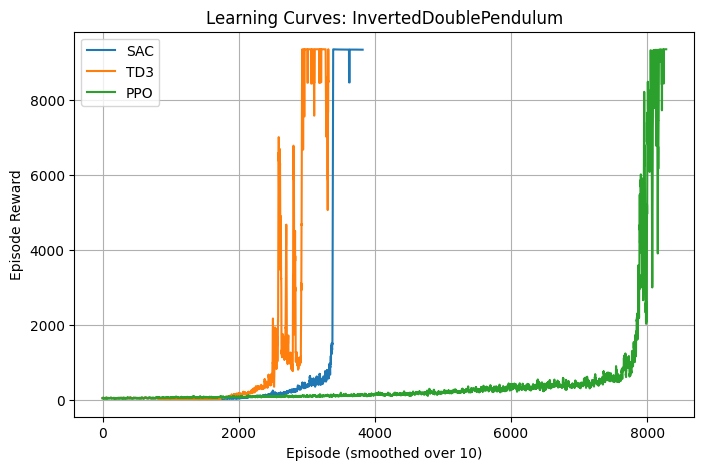

In [52]:
plot_learning_curves(algo_episode_rewards, window=10, save_path="./learning_curves.png")


In [53]:
print("=== Deterministic Policy Evaluation ===")
det_results = {}

for algo, model in all_models.items():
    mean_r, std_r = evaluate_deterministic_policy(
        model, env_id=env_id, n_eval_episodes=20, render=False
    )
    det_results[algo] = (mean_r, std_r)
    print(f"{algo}: mean reward = {mean_r:.2f} +/- {std_r:.2f}")

det_results


=== Deterministic Policy Evaluation ===
SAC: mean reward = 9354.95 +/- 0.10
TD3: mean reward = 9358.38 +/- 1.45
PPO: mean reward = 9358.90 +/- 0.14


{'SAC': (np.float64(9354.950176100001), np.float64(0.09779261451811015)),
 'TD3': (np.float64(9358.381422499999), np.float64(1.4491257492298322)),
 'PPO': (np.float64(9358.904446600001), np.float64(0.14406625181750515))}

In [54]:
save_dir = "./trained_models"
os.makedirs(save_dir, exist_ok=True)

for algo, model in all_models.items():
    path = os.path.join(save_dir, f"{algo}_inverted_double_pendulum")
    model.save(path)
    print(f"Saved {algo} model to {path}")


Saved SAC model to ./trained_models/SAC_inverted_double_pendulum
Saved TD3 model to ./trained_models/TD3_inverted_double_pendulum
Saved PPO model to ./trained_models/PPO_inverted_double_pendulum


In [55]:
import os
import imageio.v2 as imageio  # already installed

def record_gif(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    gif_path: str = "videos/td3_final.gif",
    max_steps: int = 1000,
    deterministic: bool = True,
    fps: int = 30,
):
    """
    Roll out one episode with the given model and save it as a GIF.
    """
    os.makedirs(os.path.dirname(gif_path) or ".", exist_ok=True)

    env = gym.make(env_id, render_mode="rgb_array")
    obs, info = env.reset()

    frames = []

    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        frame = env.render()  # (H, W, 3) numpy array
        frames.append(frame)

        if terminated or truncated:
            break

    env.close()

    # duration is seconds per frame
    duration = 1.0 / fps
    imageio.mimsave(gif_path, frames, duration=duration)
    print(f"Saved GIF to {gif_path}")



In [56]:
td3_model = all_models["TD3"]
record_gif(
    td3_model,
    env_id="InvertedDoublePendulum-v4",
    gif_path="videos/td3_final.gif",
    max_steps=1000,
    deterministic=True,
    fps=30,
)


Saved GIF to videos/td3_final.gif


In [57]:
sac_model = all_models["SAC"]
record_gif(sac_model, gif_path="videos/sac_final.gif")

ppo_model = all_models["PPO"]
record_gif(ppo_model, gif_path="videos/ppo_final.gif")


Saved GIF to videos/sac_final.gif
Saved GIF to videos/ppo_final.gif
